In [1]:
#!pip install --upgrade tensorflow
!pip install keras==2.12.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 2.12.0 which is incompatible.


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Dropout
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
import plotly.express as px
%matplotlib inline
pd.plotting.register_matplotlib_converters()
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#Data Preprocessing Function


In [3]:
def preprocess_data(df, scaler_type='MinMax'):
    df['date_time'] = pd.to_datetime(df['date_time'])
    features = df[['maxtempC', 'mintempC',   'uvIndex', 'WindGustKmph', 'cloudcover', 'humidity', 'pressure', 'tempC', 'visibility',
                   'winddirDegree', 'windspeedKmph', 'DewPointC', 'FeelsLikeC', 'WindChillC']]
    target = df['precipMM']*25.4  #converting to mm

    if scaler_type == 'MinMax':
        scaler_features = MinMaxScaler()
        scaler_target = MinMaxScaler()
    elif scaler_type == 'Standard':
        scaler_features = StandardScaler()
        scaler_target = StandardScaler()
    else:
        raise ValueError("Invalid value for scaler_type. Use 'MinMax' or 'Standard'.")

    features_scaled = scaler_features.fit_transform(features)
    target_scaled = scaler_target.fit_transform(target.values.reshape(-1, 1))

    return features_scaled, target_scaled, scaler_features, scaler_target

#Data Split Function

In [4]:
def split_data(features, target, test_size=0.3, val_size=0.2):
    # Split data into training, testing, and validation sets

    # Split data into 70% training and 30% testing
    X_train1, X_test, Y_train1, y_test = train_test_split(features, target, test_size=test_size, random_state=42)

    # Then split 70% of training into 50% training and 20% validation
    X_train, X_val, y_train, y_val = train_test_split(X_train1, Y_train1, test_size=val_size / (1 - test_size), random_state=42)

    return X_train, X_test, X_val, y_train, y_test, y_val


#Building RNN Model

In [15]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dropout, Dense
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from keras.layers import BatchNormalization

def build_rnn_model(input_shape, activation, optimizer):
    model = Sequential()
    model.add(SimpleRNN(32, input_shape=input_shape, activation=activation, return_sequences=True))
   # model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(SimpleRNN(16, activation=activation))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=optimizer, loss='mse')
    return model

In [16]:
# @title Function to train and evaluate RNN model
def train_evaluate_rnn(X_train, y_train, X_val, y_val, X_test, y_test, input_shape, activation, optimizer, epochs, batch_size=64):
    model = build_rnn_model(input_shape, activation, optimizer)
    es = EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[es])

    # Plot training and validation losses
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('RNN Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Evaluate on test set
    y_pred_scaled = model.predict(X_test)

    # Inverse transform the scaled predictions
    y_pred = scaler_target.inverse_transform(y_pred_scaled)

# Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Print the evaluation table
    print(f'MSE   RMSE  MAE   R2-Score ')
    print(f'{mse:.3f}  {rmse:.2f}  {mae:.3f}  {r2:.4f}')

    # Print additional information
    print(f'Mean Absolute Error on Test Set: {mae}')

    # Return the evaluation metrics if needed
    return mse, rmse, mae, r2


    mae = mean_absolute_error(y_test, y_pred)
    print(f'Mean Absolute Error on Test Set: {mae}')


#Argument Passing

In [22]:
# Example usage:
dataset = pd.read_csv('/content/drive/MyDrive/AI Flood Alert Chatbot (1)/Metrological datasets/Sukkur_Daily_Data.csv')
epochs = 60
activation = 'LeakyReLU'
optimizer = 'adam'
scaler_type = 'Standard' #''MinMax'
test_size = 0.3
val_size = 0.2


# Preprocess data

In [23]:
features, target, scaler_features, scaler_target = preprocess_data(dataset, scaler_type)


# Split data

In [24]:
X_train, X_test, X_val, y_train, y_test, y_val = split_data(features, target)

In [25]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(21903, 14)
(21903, 1)
(8762, 14)
(8762, 1)
(13143, 14)
(13143, 1)


# Build and train RNN model

Epoch 1/60
343/343 [==============================] - 6s 11ms/step - loss: 0.7496 - val_loss: 0.8423
Epoch 2/60
343/343 [==============================] - 5s 14ms/step - loss: 0.6374 - val_loss: 0.8211
Epoch 3/60
343/343 [==============================] - 3s 10ms/step - loss: 0.6308 - val_loss: 0.8356
Epoch 4/60
343/343 [==============================] - 3s 10ms/step - loss: 0.6365 - val_loss: 0.8181
Epoch 5/60
343/343 [==============================] - 3s 10ms/step - loss: 0.6263 - val_loss: 0.8222
Epoch 6/60
343/343 [==============================] - 5s 15ms/step - loss: 0.6203 - val_loss: 0.8691
Epoch 7/60
343/343 [==============================] - 3s 9ms/step - loss: 0.5993 - val_loss: 0.7970
Epoch 8/60
343/343 [==============================] - 3s 10ms/step - loss: 0.6082 - val_loss: 0.8062
Epoch 9/60
343/343 [==============================] - 4s 11ms/step - loss: 0.6059 - val_loss: 0.8072
Epoch 10/60
343/343 [==============================] - 4s 11ms/step - loss: 0.5911 - val_los

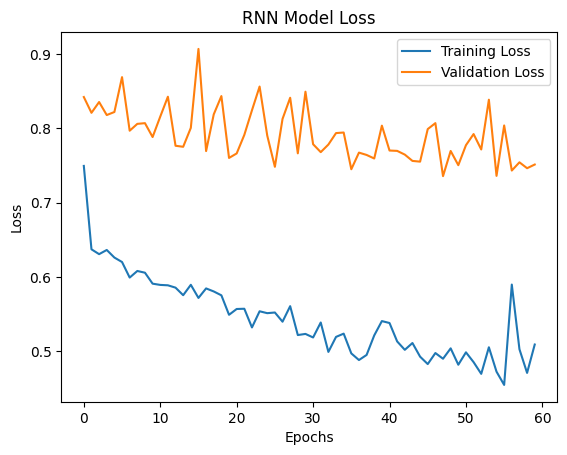

411/411 [==============================] - 1s 3ms/step
MSE   RMSE  MAE   R2-Score 
11.005  3.32  0.537  -7.8083
Mean Absolute Error on Test Set: 0.5368049886884259


(11.004549246948969, 3.317310544243479, 0.5368049886884259, -7.808255477867153)

In [26]:
# Assuming you have 14 features and each row is a timestep
input_shape_rnn = (X_train.shape[1], 1)

# Train and evaluate RNN model
train_evaluate_rnn(X_train, y_train, X_val, y_val, X_test, y_test, input_shape_rnn, activation,  optimizer, epochs)